In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  '/content/siamese_ecg_prod/dataset/Dataset_1' 

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
    
        data_train = scio.loadmat(os.path.join(root, name))
        
        # arr -> list
        data_arr = data_train.get('val')
        
        data_list = data_arr.tolist()
       
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
   
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X) # (1000, 3600)
y=np.array(y) # (1000, )

X = standardization(X)

X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


***(1000, 1, 3600) --> (samples, channels, time points)***

In [3]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] 
        self.x_train = torch.from_numpy(X_train).float().to("cuda")
        self.y_train = torch.from_numpy(y_train).long().to("cuda")
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] 
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] 
        self.x_test = torch.from_numpy(X_test).float().to("cuda")
        self.y_test = torch.from_numpy(y_test).long().to("cuda")
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] 
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [4]:
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16,stride=2,padding=7),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8,stride=4),
   
            nn.Conv1d(8,12,12,padding=5,stride=2),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(12,32,9,stride=1,padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5,stride=2),
            
            nn.Conv1d(32,64,7,stride=1,padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(64,64,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,72,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to(device)
from torchsummary import summary
summary(model, input_size=(1, 3600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 1800]             136
              ReLU-2              [-1, 8, 1800]               0
         MaxPool1d-3               [-1, 8, 449]               0
            Conv1d-4              [-1, 12, 224]           1,164
              ReLU-5              [-1, 12, 224]               0
         MaxPool1d-6              [-1, 12, 111]               0
            Conv1d-7              [-1, 32, 111]           3,488
              ReLU-8              [-1, 32, 111]               0
         MaxPool1d-9               [-1, 32, 54]               0
           Conv1d-10               [-1, 64, 54]          14,400
             ReLU-11               [-1, 64, 54]               0
        MaxPool1d-12               [-1, 64, 26]               0
           Conv1d-13               [-1, 64, 26]          20,544
             ReLU-14               [-1,

In [5]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 12, kernel_size=(12,), stride=(2,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(

## Construct Loss and Optimizer

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [7]:
correct_list = []
loss_list = []

def train(epoch):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, dim=1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
        # Print running loss every 10 batches
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            loss_list.append(running_loss / 300)  # Append average loss
            running_loss = 0.0

    # Calculate and print training accuracy after the entire epoch
    train_accuracy = 100 * correct_train / total_train
    print('Training Accuracy for epoch %d: %.8f %%' % (epoch + 1, train_accuracy))
    return train_accuracy


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    correct_list.append(accuracy)
    print('Accuracy on test set: %.8f %%' % accuracy)
    return accuracy


# Training loop
best_acc = 0
for epoch in range(180):
    train_acc = train(epoch)
    test_acc = test()
    
    if best_acc < test_acc:
        torch.save(model.state_dict(), 'best_model.pth')
        best_acc = test_acc

    # Print training accuracy for the current epoch
    print('Training Accuracy: %.8f %%' % train_acc)
    print('Test Accuracy: %.8f %%' % test_acc)


[1,    10] loss: 0.09405037
[1,    20] loss: 0.09312376
[1,    30] loss: 0.09171232
[1,    40] loss: 0.08603604
[1,    50] loss: 0.08025985
Training Accuracy for epoch 1: 28.25000000 %
Accuracy on test set: 28.00000000 %
Training Accuracy: 28.25000000 %
Test Accuracy: 28.00000000 %
[2,    10] loss: 0.08186399
[2,    20] loss: 0.08090680
[2,    30] loss: 0.07858449
[2,    40] loss: 0.07957199
[2,    50] loss: 0.07698296
Training Accuracy for epoch 2: 28.00000000 %
Accuracy on test set: 29.00000000 %
Training Accuracy: 28.00000000 %
Test Accuracy: 29.00000000 %
[3,    10] loss: 0.07782376
[3,    20] loss: 0.07847129
[3,    30] loss: 0.07637848
[3,    40] loss: 0.07998916
[3,    50] loss: 0.07997195
Training Accuracy for epoch 3: 28.25000000 %
Accuracy on test set: 28.50000000 %
Training Accuracy: 28.25000000 %
Test Accuracy: 28.50000000 %
[4,    10] loss: 0.07914978
[4,    20] loss: 0.07603330
[4,    30] loss: 0.07995746
[4,    40] loss: 0.07502263
[4,    50] loss: 0.07910958
Training Ac

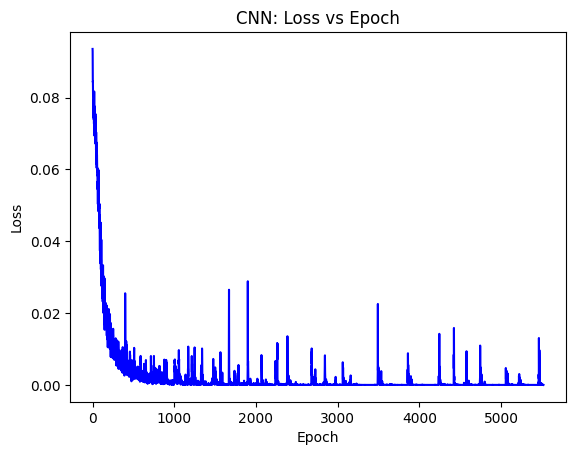

In [8]:
# Plotting loss vs epoch
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
plt.plot(loss_list, 'b')
plt.title('CNN: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_vs_epoch.png', dpi=650)
plt.show()

In [8]:
correct = 0
total = 0

test_model = arrhythmia_classifier().to(device)
test_model.load_state_dict(torch.load('/content/siamese_ecg_prod/cnn/best_model.pth'))

with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 96 %


/tmp/ipykernel_49413/2481082511.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('/content/siamese_ecg_prod/cnn/best_model.pth'))


In [18]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  '/content/siamese_ecg_prod/DatasetWave_1D_2' 

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
    
        data_train = scio.loadmat(os.path.join(root, name))
        
        # arr -> list
        data_arr = data_train.get('val')
        
        data_list = data_arr.tolist()
       
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 0)  # name -> num
   
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X) # (1000, 3600)
y=np.array(y) # (1000, )

X = standardization(X)

X_val = X.reshape((4464,1,3600))
y_val = y.reshape((4464))

class ValDataset(Dataset):
    def __init__(self):
        self.len = X_val.shape[0] 
        self.x_val = torch.from_numpy(X_val).float().to("cuda")
        self.y_val = torch.from_numpy(y_val).long().to("cuda")
    def __getitem__(self, index):
        return self.x_val[index], self.y_val[index] 
    def __len__(self):
        return self.len    
        
val_dataset = ValDataset()
val_loader = DataLoader(dataset=val_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

correct = 0
total = 0

test_model = arrhythmia_classifier().to(device)
test_model.load_state_dict(torch.load('/content/siamese_ecg_prod/cnn/best_model.pth'))

with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
print('Accuracy on val set: %.5f %%' % (100 * correct / total))

(4464, 3600)


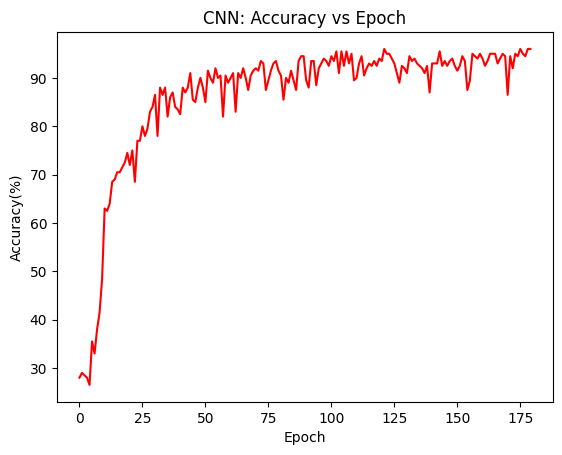

In [9]:
plt.rcParams['axes.grid'] = False
plt.plot(correct_list,'r')
plt.title('CNN: Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.savefig('accuracy vs epoch.png',dpi=650)

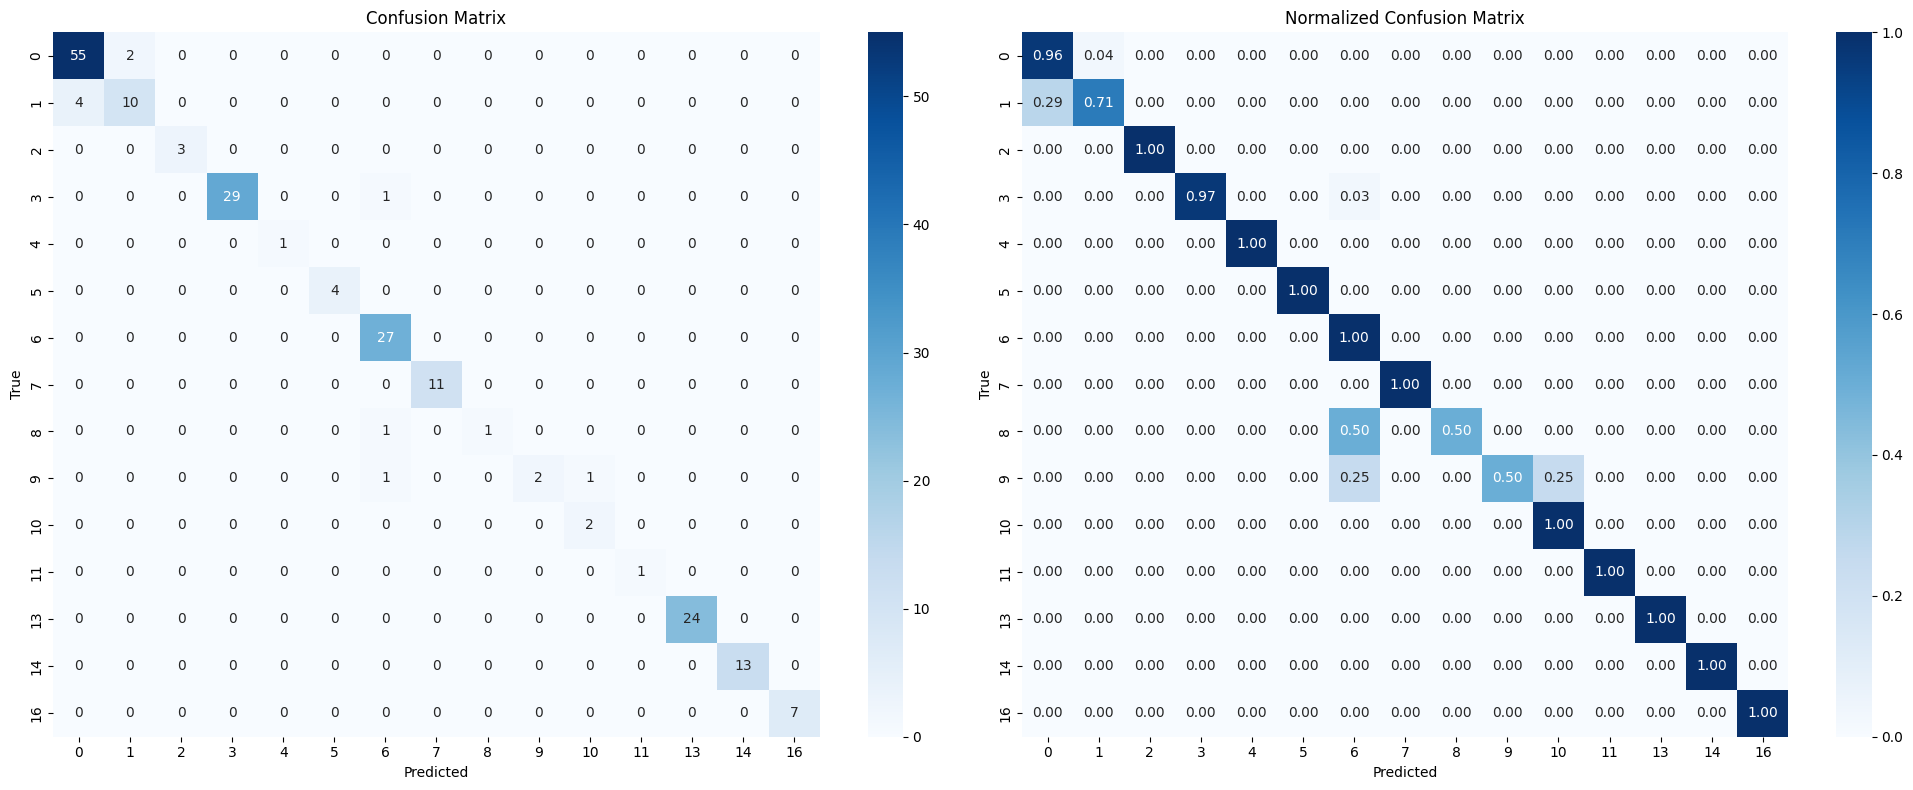

Accuracy: 0.95000
F1 Score: 0.94746
Precision: 0.95218
Recall: 0.95000
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.96      0.95        57
     Class 1       0.83      0.71      0.77        14
     Class 2       1.00      1.00      1.00         3
     Class 3       1.00      0.97      0.98        30
     Class 4       1.00      1.00      1.00         1
     Class 5       1.00      1.00      1.00         4
     Class 6       0.90      1.00      0.95        27
     Class 7       1.00      1.00      1.00        11
     Class 8       1.00      0.50      0.67         2
     Class 9       1.00      0.50      0.67         4
    Class 10       0.67      1.00      0.80         2
    Class 11       1.00      1.00      1.00         1
    Class 13       1.00      1.00      1.00        24
    Class 14       1.00      1.00      1.00        13
    Class 16       1.00      1.00      1.00         7

    accuracy                           

In [14]:
# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1, keepdim=True)
        all_preds.extend(preds.cpu().numpy().flatten())  # Flatten predictions to 1D array
        all_labels.extend(target.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Determine unique classes from the data
unique_classes = np.unique(np.concatenate((all_labels, all_preds)))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrices
plt.figure(figsize=(20, 8))

# Non-normalized confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Normalized confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()

plt.savefig('confusion_matrix4.png', dpi=650)
plt.show()
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.5f}')
print(f'F1 Score: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')

# Print detailed classification report
target_names = [f'Class {i}' for i in unique_classes]
report = classification_report(all_labels, all_preds, target_names=target_names)
print('Classification Report:\n', report)



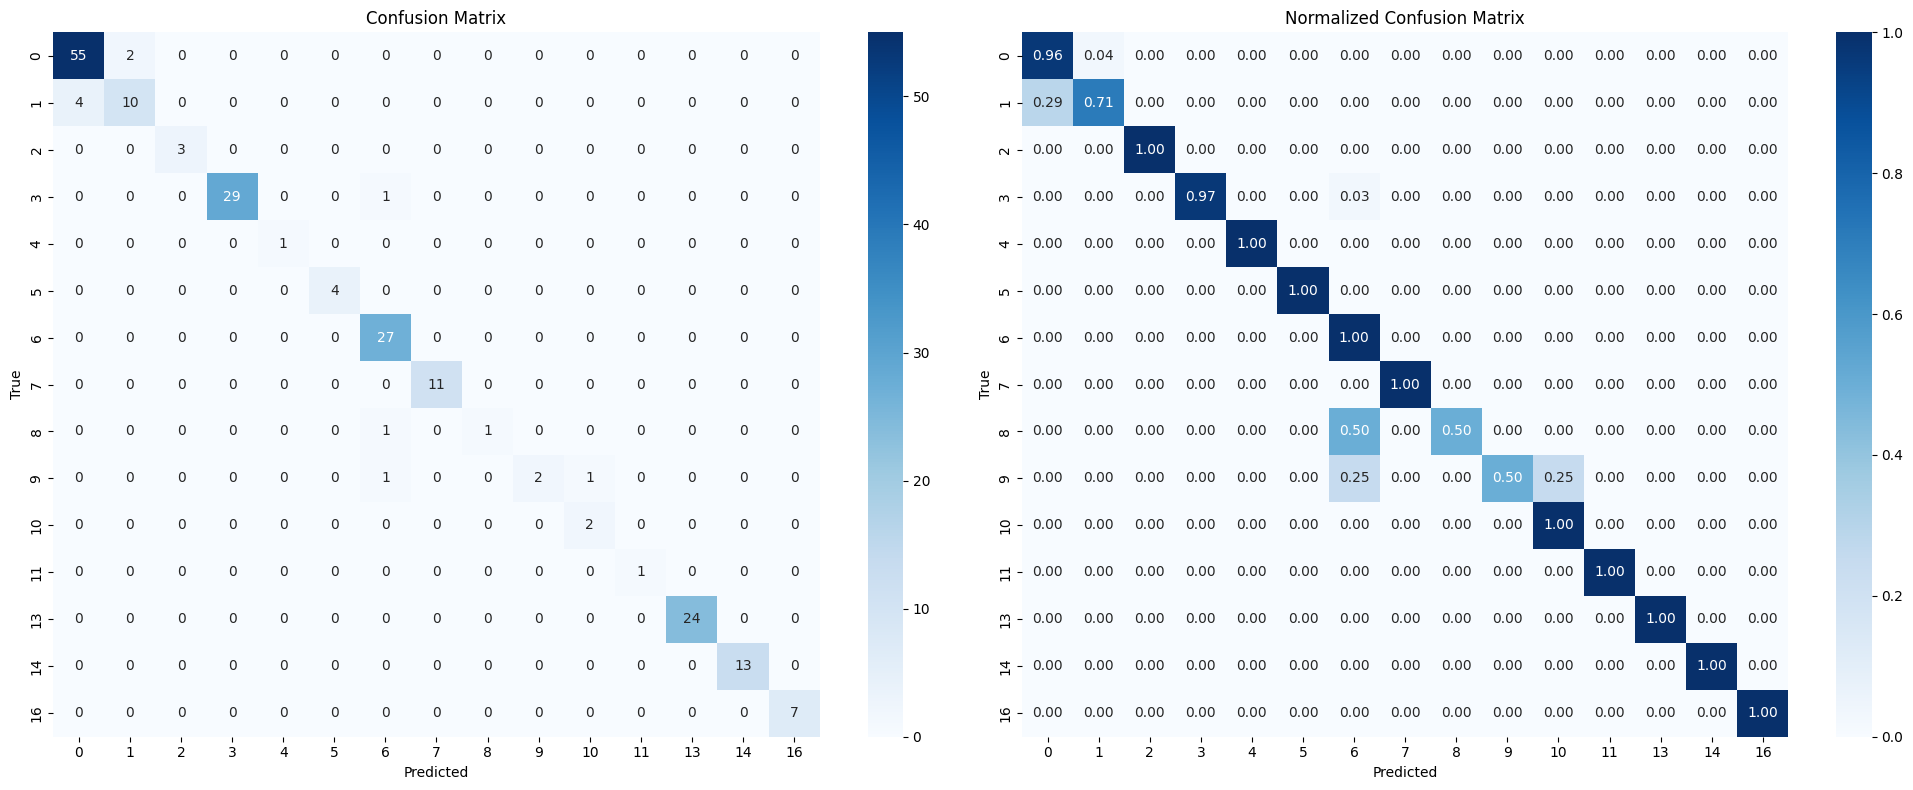

Overall Accuracy: 0.95000
F1 Score: 0.94746
Precision: 0.95218
Recall: 0.95000

Classification Report:
Class     Precision Recall    F1-Score  Accuracy  
--------------------------------------------------
0         0.93      0.96      0.95      0.96      
1         0.83      0.71      0.77      0.71      
2         1.00      1.00      1.00      1.00      
3         1.00      0.97      0.98      0.97      
4         1.00      1.00      1.00      1.00      
5         1.00      1.00      1.00      1.00      
6         0.90      1.00      0.95      1.00      
7         1.00      1.00      1.00      1.00      
8         1.00      0.50      0.67      0.50      
9         1.00      0.50      0.67      0.50      
10        0.67      1.00      0.80      1.00      
11        1.00      1.00      1.00      1.00      
13        1.00      1.00      1.00      1.00      
14        1.00      1.00      1.00      1.00      
16        1.00      1.00      1.00      1.00      


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1, keepdim=True)
        all_preds.extend(preds.cpu().numpy().flatten())  # Flatten predictions to 1D array
        all_labels.extend(target.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Determine unique classes from the data
unique_classes = np.unique(np.concatenate((all_labels, all_preds)))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrices
plt.figure(figsize=(20, 8))

# Non-normalized confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Normalized confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig('conf.png', dpi=650)
plt.show()

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

# Print overall metrics
print(f'Overall Accuracy: {accuracy:.5f}')
print(f'F1 Score: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print detailed classification report with class accuracies
print('\nClassification Report:')
print(f"{'Class':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Accuracy':<10}")
print('-' * 50)
for i, cls in enumerate(unique_classes):
    precision = precision_score(all_labels, all_preds, labels=[cls], average='micro')
    recall = recall_score(all_labels, all_preds, labels=[cls], average='micro')
    f1 = f1_score(all_labels, all_preds, labels=[cls], average='micro')
    accuracy = class_accuracies[i]
    print(f"{cls:<10}{precision:<10.2f}{recall:<10.2f}{f1:<10.2f}{accuracy:<10.2f}")


Saliency Map

In [142]:
data, target = next(iter(test_loader))

# Assuming your model is defined as `model`
device = next(model.parameters()).device  # Get device from model parameters
data = data.to(device)
target = target.to(device)

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt

# Initialize lists to store true labels and prediction scores
all_labels = []
all_scores = []

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_scores.append(output.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Convert lists to numpy arrays
all_scores = np.concatenate(all_scores, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize the labels for multi-class
y_test_binarized = label_binarize(all_labels, classes=unique_classes)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'brown', 'gray'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {unique_classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [3000, 3400]

In [18]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Initialize lists to store true labels and prediction scores
all_labels = []
all_scores = []

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_scores.append(output.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Convert lists to numpy arrays
all_scores = np.concatenate(all_scores, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Ensure that the shapes are consistent
print("Shape of all_scores:", all_scores.shape)
print("Shape of all_labels:", all_labels.shape)

# Binarize the labels for multi-class
unique_classes = np.unique(all_labels)  # Make sure unique_classes are defined
y_test_binarized = label_binarize(all_labels, classes=unique_classes)
n_classes = y_test_binarized.shape[1]

# Ensure consistency
assert y_test_binarized.shape[0] == all_scores.shape[0], "Mismatch in number of samples between binarized labels and scores"

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'brown', 'gray'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {unique_classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Shape of all_scores: (200, 17)
Shape of all_labels: (200,)


ValueError: Found input variables with inconsistent numbers of samples: [3000, 3400]

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store true labels and prediction scores
all_labels = []
all_scores = []

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_scores.append(output.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Convert lists to numpy arrays
all_scores = np.concatenate(all_scores, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize the labels for multi-class
y_test_binarized = label_binarize(all_labels, classes=unique_classes)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), all_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plotting the micro-average ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC curve (area = {roc_auc_micro:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve with AUC (Micro-Average)')
plt.legend(loc="lower right")
# plt.savefig('roc_curve.png', dpi=650)
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [3000, 3400]

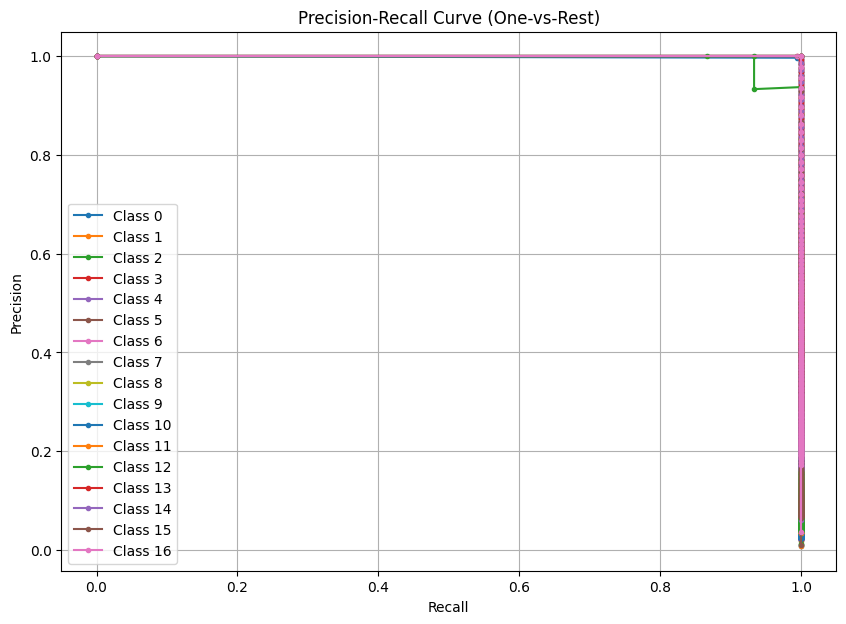

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_scores = []

def test_with_scores():
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # For multiclass classification
            
            # Storing true labels and prediction scores
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())  # Store probabilities for all classes

    return np.array(y_true), np.array(y_scores)

# Call test_with_scores after the training loop
y_true, y_scores = test_with_scores()

# Binarize the labels for multiclass precision-recall computation (one-vs-rest)
num_classes = y_scores.shape[1]
y_true_bin = label_binarize(y_true, classes=[i for i in range(num_classes)])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 7))

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
# plt.savefig('precision_recall_curve_multiclass.png', dpi=650)
plt.show()


In [1]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_scores = []

def test_with_scores():
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for all classes
            
            # Storing true labels and prediction scores
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())  # Store probabilities for all classes

    return np.array(y_true), np.array(y_scores)

# Call test_with_scores after the training loop
y_true, y_scores = test_with_scores()

# Binarize the labels for multiclass precision-recall computation
num_classes = y_scores.shape[1]
y_true_bin = label_binarize(y_true, classes=[i for i in range(num_classes)])

# Compute precision-recall curve and average precision score using micro averaging
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_scores.ravel())
average_precision = average_precision_score(y_true_bin, y_scores, average="micro")

# Plotting overall precision-recall curve
plt.plot(recall, precision, marker='.')
plt.title(f'Overall Precision-Recall Curve (micro-average), AP={average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('overall_precision_recall_curve1.png', dpi=650)
plt.show()


NameError: name 'model' is not defined

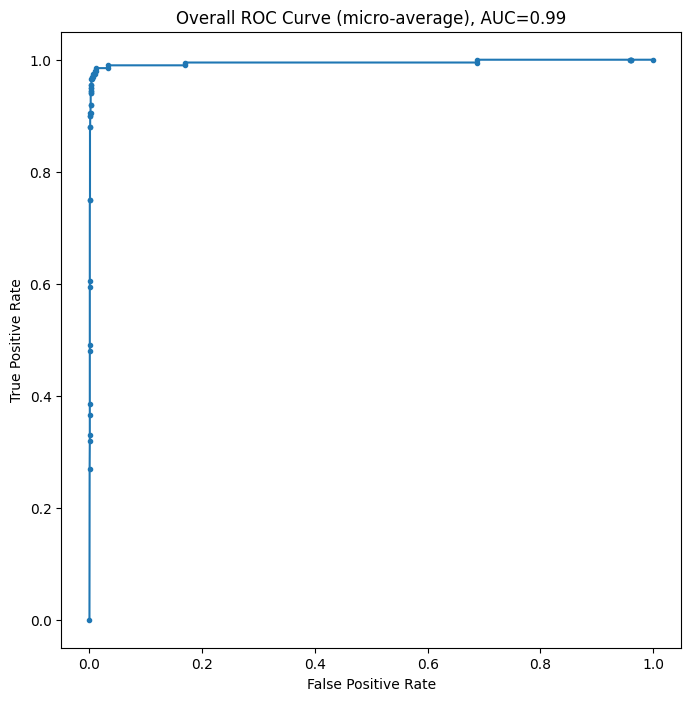

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# Initialize y_true and y_scores as lists
y_true = []
y_scores = []

def test_with_scores():
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for all classes
            
            # Storing true labels and prediction scores
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())  # Store probabilities for all classes

    return np.array(y_true), np.array(y_scores)

# Call test_with_scores after the training loop
y_true, y_scores = test_with_scores()

# Binarize the labels for multiclass evaluation
num_classes = y_scores.shape[1]
y_true_bin = label_binarize(y_true, classes=[i for i in range(num_classes)])

# Compute ROC Curve and AUC Score using micro averaging
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
roc_auc = roc_auc_score(y_true_bin, y_scores, average="micro")

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, marker='.')
plt.title(f'Overall ROC Curve (micro-average), AUC={roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('overall_roc_curve.png', dpi=650)
plt.show()
